In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy import sparse
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , merge
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop,Nadam
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau
from keras.layers.merge import dot
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split
from numba import jit # Compile some functions when performance is critical
import keras
from keras.initializers import RandomNormal
from keras.models import Model, load_model, save_model
from keras.layers import Embedding, Input, Dense, Concatenate, Multiply, Flatten,Dropout
from keras.optimizers import Adam
import tensorflow as tf

In [2]:
data1= pd.read_csv('Dataset/BookDetails.csv')

In [3]:
book = data1[['book_id','text_reviews_count','average_rating','publisher','publication_year',
             'ratings_count','genre1']]

In [4]:
book

,book_id,text_reviews_count,average_rating,publisher,publication_year,ratings_count,genre1
0,10365,7868,4.04,Yearling,2000.0,271951,children
1,10959,4324,3.88,Phoenix,1995.0,111215,children
2,5,28561,4.53,Scholastic Inc.,2004.0,1876252,children
3,11387515,31536,4.43,Knopf,2012.0,255461,children_YoungAdult
4,438492,3313,3.91,HarperCollins Publishers,2000.0,121250,children
...,...,...,...,...,...,...,...
19288,25698127,140,4.01,Penguin Teen Australia,2016.0,533,YoungAdult
19289,13919896,48,3.58,HarperTeen,2014.0,177,YoungAdult
19290,8129464,229,4.07,Puffin,2010.0,3295,YoungAdult
19291,10860716,78,3.84,HarperCollins Canada,2011.0,258,YoungAdult


In [5]:
data1= pd.read_csv('Dataset/UserInteractionV1.csv')

In [6]:
data2 = data1[['user_id','book_id','rating']]

In [7]:
data2 = data2.loc[:, ~data2.columns.str.contains('^Unnamed')]

In [8]:
users = data2.user_id.unique()
Books = data2.book_id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
Bookid2idx = {o:i for i,o in enumerate(Books)}

In [9]:
data2['user_id'] = data2['user_id'].apply(lambda x: userid2idx[x])
data2['book_id'] = data2['book_id'].apply(lambda x: Bookid2idx[x])

In [10]:
book['book_id'] = book['book_id'].apply(lambda x: Bookid2idx[x])
book

,book_id,text_reviews_count,average_rating,publisher,publication_year,ratings_count,genre1
0,0,7868,4.04,Yearling,2000.0,271951,children
1,1,4324,3.88,Phoenix,1995.0,111215,children
2,2,28561,4.53,Scholastic Inc.,2004.0,1876252,children
3,3,31536,4.43,Knopf,2012.0,255461,children_YoungAdult
4,4,3313,3.91,HarperCollins Publishers,2000.0,121250,children
...,...,...,...,...,...,...,...
19288,19288,140,4.01,Penguin Teen Australia,2016.0,533,YoungAdult
19289,19289,48,3.58,HarperTeen,2014.0,177,YoungAdult
19290,19290,229,4.07,Puffin,2010.0,3295,YoungAdult
19291,19291,78,3.84,HarperCollins Canada,2011.0,258,YoungAdult


In [11]:
data2

,user_id,book_id,rating
0,0,0,5
1,1,0,5
2,2,0,5
3,3,0,5
4,4,0,5
...,...,...,...
1114794,10800,19292,4
1114795,11917,19292,4
1114796,5572,19292,5
1114797,11417,19292,4


In [12]:
G=pd.read_csv('Dataset/GMM_v2.csv')

In [13]:
G

,Unnamed: 0,book_id,0,1,2,3,4,5,6,7
0,0,10365,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
1,1,10959,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
2,2,5,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.000
3,3,11387515,0.0,0.0,0.0,0.000,0.0,1.0,0.0,0.000
4,4,438492,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...
19288,19288,25698127,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
19289,19289,13919896,0.0,0.0,0.0,1.000,0.0,0.0,0.0,0.000
19290,19290,8129464,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
19291,19291,10860716,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000


In [14]:
G = G.loc[:, ~G.columns.str.contains('^Unnamed')]

In [15]:
G['book_id'] = G['book_id'].apply(lambda x: Bookid2idx[x])

In [16]:
G

,book_id,0,1,2,3,4,5,6,7
0,0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
1,1,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
2,2,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.000
3,3,0.0,0.0,0.0,0.000,0.0,1.0,0.0,0.000
4,4,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...
19288,19288,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
19289,19289,0.0,0.0,0.0,1.000,0.0,0.0,0.0,0.000
19290,19290,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
19291,19291,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000


In [17]:
book['features_genre'] = book['genre1']

In [18]:
book['features_genre'] = book['features_genre'].map(lambda x: x.split('_'))

In [19]:
book

,book_id,text_reviews_count,average_rating,publisher,publication_year,ratings_count,genre1,features_genre
0,0,7868,4.04,Yearling,2000.0,271951,children,[children]
1,1,4324,3.88,Phoenix,1995.0,111215,children,[children]
2,2,28561,4.53,Scholastic Inc.,2004.0,1876252,children,[children]
3,3,31536,4.43,Knopf,2012.0,255461,children_YoungAdult,"[children, YoungAdult]"
4,4,3313,3.91,HarperCollins Publishers,2000.0,121250,children,[children]
...,...,...,...,...,...,...,...,...
19288,19288,140,4.01,Penguin Teen Australia,2016.0,533,YoungAdult,[YoungAdult]
19289,19289,48,3.58,HarperTeen,2014.0,177,YoungAdult,[YoungAdult]
19290,19290,229,4.07,Puffin,2010.0,3295,YoungAdult,[YoungAdult]
19291,19291,78,3.84,HarperCollins Canada,2011.0,258,YoungAdult,[YoungAdult]


In [20]:
all_genres = set()
for row in book['features_genre']:
    # Union of sets is declared with the | operator
    all_genres = all_genres | set(row)
#all_genres.remove('') # Drop the empty genre

def invert_dict(d):
    return {value: key for key, value in d.items()}

all_genres = sorted(list(all_genres)) # We convert it to a list to enforce alphabetic ordering
ngenres = len(all_genres)

idx2genre = dict(enumerate(all_genres)) # Create a mapping dictionary from index to dict
genre2idx = invert_dict(idx2genre) # Inverse dict

genre2idx

{'YoungAdult': 0,
 'biography': 1,
 'children': 2,
 'comics-graphic': 3,
 'crime': 4,
 'fantasy': 5,
 'history': 6,
 'mystery': 7,
 'paranormal': 8,
 'poetry': 9,
 'romance': 10,
 'thriller': 11}

In [21]:
def encode_genres(genres):
    out = np.zeros(ngenres)
    for genre in genres:
        if genre == '':
            pass
        else:
            out[genre2idx[genre]] = 1
    return out.tolist()
book['features_genre'] = book['features_genre'].map(encode_genres)
book['features_genre']

0        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
19288    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
19289    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
19290    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
19291    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
19292    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: features_genre, Length: 19293, dtype: object

In [22]:
book['Pub1'] = book['publication_year']

In [23]:
book["PY1"] = ""

In [24]:
book

,book_id,text_reviews_count,average_rating,publisher,publication_year,ratings_count,genre1,features_genre,Pub1,PY1
0,0,7868,4.04,Yearling,2000.0,271951,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000.0,
1,1,4324,3.88,Phoenix,1995.0,111215,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1995.0,
2,2,28561,4.53,Scholastic Inc.,2004.0,1876252,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2004.0,
3,3,31536,4.43,Knopf,2012.0,255461,children_YoungAdult,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2012.0,
4,4,3313,3.91,HarperCollins Publishers,2000.0,121250,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000.0,
...,...,...,...,...,...,...,...,...,...,...
19288,19288,140,4.01,Penguin Teen Australia,2016.0,533,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2016.0,
19289,19289,48,3.58,HarperTeen,2014.0,177,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2014.0,
19290,19290,229,4.07,Puffin,2010.0,3295,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2010.0,
19291,19291,78,3.84,HarperCollins Canada,2011.0,258,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2011.0,


In [25]:
for i in range(len(book)):
    if book.iloc[i][8]>=2000.0:
        book.iat[i,9]='a'
    elif book.iloc[i][8]>=1950.0 and book.iloc[i][8]<2000.0:
        book.iat[i,9]='b'
    elif book.iloc[i][8]=="NaN":
        book.iat[i,9]=''
    else:
        book.iat[i,9]='d'

In [26]:
book

,book_id,text_reviews_count,average_rating,publisher,publication_year,ratings_count,genre1,features_genre,Pub1,PY1
0,0,7868,4.04,Yearling,2000.0,271951,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000.0,a
1,1,4324,3.88,Phoenix,1995.0,111215,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1995.0,b
2,2,28561,4.53,Scholastic Inc.,2004.0,1876252,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2004.0,a
3,3,31536,4.43,Knopf,2012.0,255461,children_YoungAdult,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2012.0,a
4,4,3313,3.91,HarperCollins Publishers,2000.0,121250,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000.0,a
...,...,...,...,...,...,...,...,...,...,...
19288,19288,140,4.01,Penguin Teen Australia,2016.0,533,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2016.0,a
19289,19289,48,3.58,HarperTeen,2014.0,177,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2014.0,a
19290,19290,229,4.07,Puffin,2010.0,3295,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2010.0,a
19291,19291,78,3.84,HarperCollins Canada,2011.0,258,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2011.0,a


In [27]:
book['PY1'] = book['PY1'].map(lambda x: x)

In [28]:
all_year = set()
for row in book['PY1']:
    # Union of sets is declared with the | operator
    all_year = all_year | set(row)
#all_genres.remove('') # Drop the empty genre

def invert_dict(d):
    return {value: key for key, value in d.items()}

all_year = sorted(list(all_year)) # We convert it to a list to enforce alphabetic ordering
nyear = len(all_year)

idx2year= dict(enumerate(all_year)) # Create a mapping dictionary from index to dict
year2idx = invert_dict(idx2year) # Inverse dict

year2idx

{'a': 0, 'b': 1, 'd': 2}

In [29]:
def encode_year(years):
    out = np.zeros(nyear)
    for year in years:
        if year == '':
            pass
        else:
            out[year2idx[year]] = 1
    return out.tolist()
book['PY1'] = book['PY1'].map(encode_year)
book['PY1']

0        [1.0, 0.0, 0.0]
1        [0.0, 1.0, 0.0]
2        [1.0, 0.0, 0.0]
3        [1.0, 0.0, 0.0]
4        [1.0, 0.0, 0.0]
              ...       
19288    [1.0, 0.0, 0.0]
19289    [1.0, 0.0, 0.0]
19290    [1.0, 0.0, 0.0]
19291    [1.0, 0.0, 0.0]
19292    [1.0, 0.0, 0.0]
Name: PY1, Length: 19293, dtype: object

In [30]:
book

,book_id,text_reviews_count,average_rating,publisher,publication_year,ratings_count,genre1,features_genre,Pub1,PY1
0,0,7868,4.04,Yearling,2000.0,271951,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000.0,"[1.0, 0.0, 0.0]"
1,1,4324,3.88,Phoenix,1995.0,111215,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1995.0,"[0.0, 1.0, 0.0]"
2,2,28561,4.53,Scholastic Inc.,2004.0,1876252,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2004.0,"[1.0, 0.0, 0.0]"
3,3,31536,4.43,Knopf,2012.0,255461,children_YoungAdult,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2012.0,"[1.0, 0.0, 0.0]"
4,4,3313,3.91,HarperCollins Publishers,2000.0,121250,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000.0,"[1.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...
19288,19288,140,4.01,Penguin Teen Australia,2016.0,533,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2016.0,"[1.0, 0.0, 0.0]"
19289,19289,48,3.58,HarperTeen,2014.0,177,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2014.0,"[1.0, 0.0, 0.0]"
19290,19290,229,4.07,Puffin,2010.0,3295,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2010.0,"[1.0, 0.0, 0.0]"
19291,19291,78,3.84,HarperCollins Canada,2011.0,258,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2011.0,"[1.0, 0.0, 0.0]"


In [31]:
G["book"]=G.apply(lambda x: [x])

In [32]:
G1=G

In [33]:
G1

,book_id,0,1,2,3,4,5,6,7,book
0,0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000,NaN
1,1,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000,NaN
2,2,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.000,NaN
3,3,0.0,0.0,0.0,0.000,0.0,1.0,0.0,0.000,NaN
4,4,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...
19288,19288,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000,NaN
19289,19289,0.0,0.0,0.0,1.000,0.0,0.0,0.0,0.000,NaN
19290,19290,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000,NaN
19291,19291,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000,NaN


In [34]:
G1.drop(['book_id', 'book'], axis=1)

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
1,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
2,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.000
3,0.0,0.0,0.0,0.000,0.0,1.0,0.0,0.000
4,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...
19288,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
19289,0.0,0.0,0.0,1.000,0.0,0.0,0.0,0.000
19290,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000
19291,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000


In [35]:
G1['combined']= G1.values.tolist()

In [27]:
#G1['combined']= G1.values.tolist()

In [36]:
G1=G1.drop(['book_id', 'book','combined'], axis=1)

In [37]:
G1['combined']= G1.values.tolist()

In [38]:
G1

,0,1,2,3,4,5,6,7,combined
0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,0.0,0.0,0.0,0.000,0.0,1.0,0.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,0.0,1.0,0.0,0.000,0.0,0.0,0.0,0.000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...
19288,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
19289,0.0,0.0,0.0,1.000,0.0,0.0,0.0,0.000,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
19290,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
19291,0.0,0.0,0.0,0.000,0.0,0.0,0.0,1.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [39]:
book['features1'] = book['features_genre'] + book['PY1']+G1['combined']

In [40]:
book

,book_id,text_reviews_count,average_rating,publisher,publication_year,ratings_count,genre1,features_genre,Pub1,PY1,features1
0,0,7868,4.04,Yearling,2000.0,271951,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000.0,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,4324,3.88,Phoenix,1995.0,111215,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1995.0,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,28561,4.53,Scholastic Inc.,2004.0,1876252,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2004.0,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,31536,4.43,Knopf,2012.0,255461,children_YoungAdult,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2012.0,"[1.0, 0.0, 0.0]","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,3313,3.91,HarperCollins Publishers,2000.0,121250,children,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000.0,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
19288,19288,140,4.01,Penguin Teen Australia,2016.0,533,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2016.0,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19289,19289,48,3.58,HarperTeen,2014.0,177,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2014.0,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19290,19290,229,4.07,Puffin,2010.0,3295,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2010.0,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19291,19291,78,3.84,HarperCollins Canada,2011.0,258,YoungAdult,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2011.0,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [41]:
n_feats = len(book['features1'].iloc[0])

In [42]:
n_feats

23

In [45]:
data2

,user_id,book_id,rating
0,0,0,5
1,1,0,5
2,2,0,5
3,3,0,5
4,4,0,5
...,...,...,...
1114794,10800,19292,4
1114795,11917,19292,4
1114796,5572,19292,5
1114797,11417,19292,4


In [49]:
#data2=data2.drop(['features','features_genre','PY1'], axis=1)

In [67]:
data2

,user_id,book_id,rating
0,0,0,5
1,1,0,5
2,2,0,5
3,3,0,5
4,4,0,5
...,...,...,...
1114794,10800,19292,4
1114795,11917,19292,4
1114796,5572,19292,5
1114797,11417,19292,4


In [46]:
data2 = data2.join(book['features1'], on = 'book_id').dropna()

In [47]:
data2

,user_id,book_id,rating,features1
0,0,0,5,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,0,5,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,0,5,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,0,5,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,0,5,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
1114794,10800,19292,4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1114795,11917,19292,4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1114796,5572,19292,5,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1114797,11417,19292,4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [48]:
n_feats = len(data2['features1'].iloc[0])
n_feats

23

In [52]:
data=data2

In [53]:
data

,user_id,book_id,rating,features1
0,0,0,5,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,0,5,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,0,5,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,0,5,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,0,5,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
1114794,10800,19292,4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1114795,11917,19292,4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1114796,5572,19292,5,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1114797,11417,19292,4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [54]:
from sklearn.utils import shuffle
data4=data

In [55]:
data=shuffle(data)

In [56]:
x0 = data['user_id'].to_numpy()
x1 =data['book_id'].to_numpy()

In [57]:
x2 = np.stack(data['features1'].to_numpy())

In [58]:
y = data['rating'].to_numpy()

In [59]:
def get_model(num_users, num_items, num_item_feats, mf_dim, layers=[64, 32, 16, 8]):
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    feats_input = Input(shape=(num_item_feats,), dtype='float32', name = 'feats_input')

    # User&Item Embeddings for Matrix Factorization
    MF_Embedding_User = Embedding(input_dim = num_users + 1, output_dim = mf_dim,
                                  name = 'user_embedding',
                                  embeddings_initializer = RandomNormal(stddev=0.001),
                                  input_length = 1)
    MF_Embedding_Item = Embedding(input_dim = num_items + 1, output_dim = mf_dim,
                                  name = 'item_embedding',
                                  embeddings_initializer = RandomNormal(stddev=0.001),
                                  input_length = 1)
    
    # User&Item Embeddings for MLP part
    #MLP_Embedding_User = Embedding(input_dim = num_users + 1, output_dim = int(layers[0] / 2),
                                   #name = 'mlp_embedding_user',
                                  # embeddings_initializer = RandomNormal(stddev=0.001),
                                   #input_length = 1)
   # MLP_Embedding_Item = Embedding(input_dim = num_items + 1, output_dim = int(layers[0] / 2),
                                   #name = 'mlp_embedding_item',
                                   #embeddings_initializer = RandomNormal(stddev=0.001),
                                   #input_length = 1) 
    
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector =Concatenate()([mf_user_latent, mf_item_latent])
    mf_vector=Dense(96,activation='relu')(mf_vector)
    mf_vector=Dropout(0.4)(mf_vector)

    # MLP part with item features
    #mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    #mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    mlp_vector = Concatenate()([mf_vector, feats_input])
    for l in layers:
        layer = Dense(l, activation='relu')
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    #predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    prediction_1=Dense(4, activation = 'relu')(mlp_vector)
    #prediction_2=Dense(2, activation = 'relu')(prediction_1)
    # Final prediction layer
    prediction = Dense(1, activation = 'relu',
                       kernel_initializer = 'lecun_uniform',
                       name = 'prediction')(prediction_1)
    
    model = Model(input = [user_input, item_input, feats_input], output = prediction)
    return model

In [60]:
def getData(k,i):
    l=len(data4)
    l1=int(l/k)
    j=l1*(i+1)
    i=l1*i
    x0_val=x0[i:j]
    x1_val=x1[i:j]
    x2_val=x2[i:j]
    y_val=y[i:j]
    
    if i==0:
        x0_train=x0[j:l]
        x1_train=x1[j:l]
        x2_train=x2[j:l]
        y_train=y[j:l]
    elif i==k-1:
        x0_train=x0[0:i]
        x1_train=x1[0:i]
        x2_train=x2[0:i]
        y_train=y[0:i]
    else:
        x0_train=np.concatenate((x0[0:i],x0[j:l]))
        x1_train=np.concatenate((x1[0:i],x1[j:l]))
        x2_train=np.concatenate((x2[0:i],x2[j:l]))
        y_train=np.concatenate((y[0:i],y[j:l]))    
              
    x_train=[x0_train,x1_train,x2_train]
    x_val=[x0_val,x1_val,x2_val]
    
    return x_train,y_train,x_val,y_val

In [64]:
learning_rate = 0.001
batch_size = 128
#n_epochs = 20
mf_dim = 50
layers = [128,64,32, 16, 8]
n_users=len(users)
n_book=len(Books)
n_folds=10

In [62]:
def root_mean_squared_error(y_train, y_val):
        return K.sqrt(K.mean(K.square(y_val - y_train))) 

In [67]:
for i in range(n_folds):
    print("Training on Fold: ",i+1)
    
    x_train,y_train,x_val,y_val=getData(n_folds,i)
    
    model = None
    model = get_model(n_users, n_book, n_feats, mf_dim, layers)
    model.compile(optimizer = 
                  Adam(lr = 0.001), loss =root_mean_squared_error)
    results = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val),
                 batch_size = batch_size, epochs = 5, verbose = True)
    print("Val Score: ", model.evaluate(x_val, y_val))

Training on Fold:  1
Train on 1003320 samples, validate on 111479 samples
Epoch 1/5
1003320/1003320 [==============================] - 107s 107us/step - loss: 1.1324 - val_loss: 1.0891
Epoch 2/5
1003320/1003320 [==============================] - 110s 109us/step - loss: 1.0692 - val_loss: 1.0807
Epoch 3/5
1003320/1003320 [==============================] - 110s 110us/step - loss: 1.0461 - val_loss: 1.0822
Epoch 4/5
1003320/1003320 [==============================] - 110s 110us/step - loss: 1.0252 - val_loss: 1.0813
Epoch 5/5
111479/111479 [==============================] - 2s 15us/step
Val Score:  1.071930933566906
Training on Fold:  2
Train on 1003320 samples, validate on 111479 samples
Epoch 1/5
1003320/1003320 [==============================] - 120s 119us/step - loss: 1.1346 - val_loss: 1.0862
Epoch 2/5
1003320/1003320 [==============================] - 117s 117us/step - loss: 1.0689 - val_loss: 1.0846
Epoch 3/5
1003320/1003320 [==============================] - 125s 125us/step - loss:

In [50]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
mlp_embedding_user (Embedding)  (None, 1, 16)        299024      user_input[0][0]                 
__________________________________________________________________________________________________
mlp_embedding_item (Embedding)  (None, 1, 16)        308704      item_input[0][0]                 
___________________________________________________________________________________________

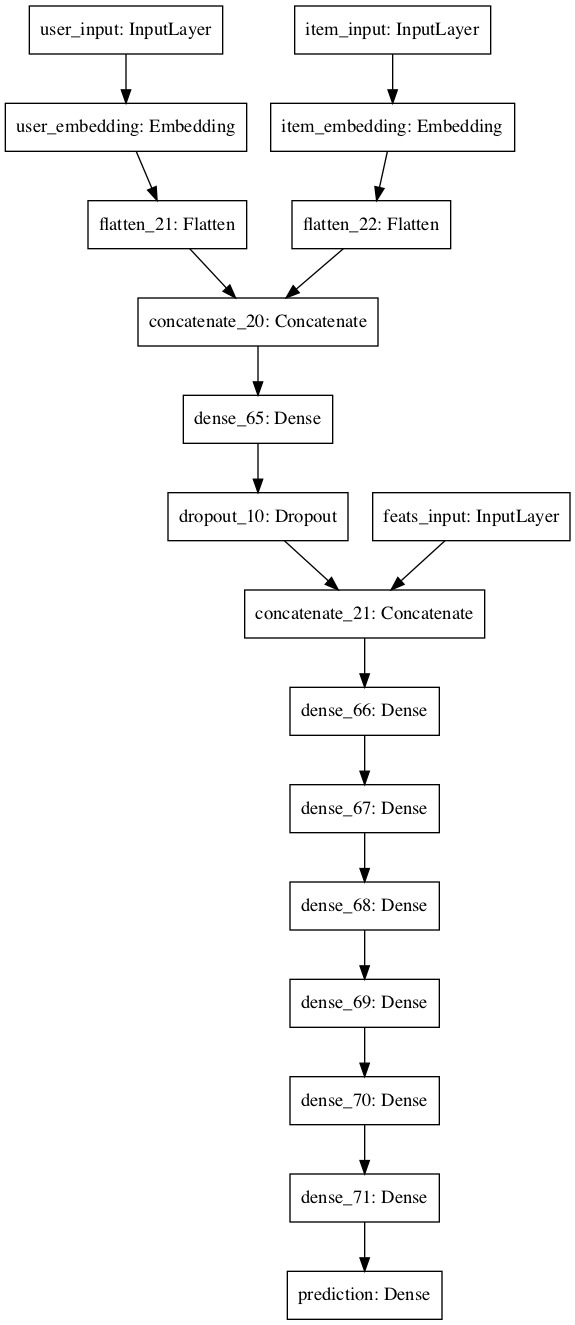

In [68]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [69]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        934450      user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 50)        964700      item_input[0][0]                 
___________________________________________________________________________________________

In [70]:
learning_rate = 0.001
batch_size = 128
#n_epochs = 20
mf_dim = 30
layers = [65,50,25,8]
n_users=len(users)
n_book=len(Books)
n_folds=10

In [71]:
for i in range(n_folds):
    print("Training on Fold: ",i+1)
    
    x_train,y_train,x_val,y_val=getData(n_folds,i)
    
    model = None
    model = get_model(n_users, n_book, n_feats, mf_dim, layers)
    model.compile(optimizer = 
                  Adam(lr = 0.001), loss =root_mean_squared_error)
    results = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val),
                 batch_size = batch_size, epochs = 5, verbose = True)
    print("Val Score: ", model.evaluate(x_val, y_val))

Training on Fold:  1
Train on 1003320 samples, validate on 111479 samples
Epoch 1/5
1003320/1003320 [==============================] - 50s 50us/step - loss: 1.1285 - val_loss: 1.0959
Epoch 2/5
1003320/1003320 [==============================] - 51s 51us/step - loss: 1.0676 - val_loss: 1.0796
Epoch 3/5
1003320/1003320 [==============================] - 56s 56us/step - loss: 1.0451 - val_loss: 1.0821
Epoch 4/5
1003320/1003320 [==============================] - 53s 53us/step - loss: 1.0255 - val_loss: 1.0805
Epoch 5/5
111479/111479 [==============================] - 2s 14us/step
Val Score:  1.070942371936362
Training on Fold:  2
Train on 1003320 samples, validate on 111479 samples
Epoch 1/5
 616448/1003320 [=================>............] - ETA: 23s - loss: 1.1443

KeyboardInterrupt: 